# Activation model and t-SNE

**Download and process the dataset**

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-21 19:10:01--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   104MB/s    in 0.6s    

2019-04-21 19:10:07 (104 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [0]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print()
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000

total validation cat images: 500
total validation dog images: 500


## Build model with VGG19 conv base and custom densely connected layers (same as Problem 2)

**Load VGG19 conv base**

In [0]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 1s 0us/step


In [0]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

**Freeze the conv base**

In [0]:
conv_base.trainable = False

**Add densely connected layers on top of the conv base**

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
# dropout
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 2,097,665
Non-trainable params: 20,024,384
_________________________________________________________________


## Train the model end to end with frozen conv base (same as Problem 2)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])


history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
100/100 [==============================] - 24s 242ms/step - loss: 0.6784 - acc: 0.5825 - val_loss: 0.5674 - val_acc: 0.7610
Epoch 2/50
100/100 [==============================] - 19s 188ms/step - loss: 0.6102 - acc: 0.6650 - val_loss: 0.4965 - val_acc: 0.8010
Epoch 3/50
100/100 [==============================] - 19s 191ms/step - loss: 0.5558 - acc: 0.7250 - val_loss: 0.4545 - val_acc: 0.8080
Epoch 4/50
100/100 [==============================] - 19s 186ms/step - loss: 0.5254 - acc: 0.7410 - val_loss: 0.4183 - val_acc: 0.8220
Epoch 5/50
100/100 [==============================] - 18s 185ms/step - loss: 0.5126 - acc: 0.7575 - val_loss: 0.4058 - val_acc: 0.8210
Epoch 6/50
100/100 [==============================] - 18s 184ms/step - loss: 0.4796 - acc: 0.7785 - val_loss: 0.3929 - val_acc: 0.8290
Epoch 7/50
100/100 [==============================] - 18s 183ms/step - loss: 0.4713 - acc: 0.7760 - val_loss: 0.3694 - val_acc: 0.8390
Epoch 8

## Fine-tuning (same as Problem 2)

In [0]:
conv_base.trainable = True

# fine-tune only the top layers of the pre-trained model (VGG19)
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [0]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/50
100/100 [==============================] - 21s 211ms/step - loss: 0.3241 - acc: 0.8635 - val_loss: 0.3142 - val_acc: 0.8730
Epoch 2/50
100/100 [==============================] - 19s 192ms/step - loss: 0.2997 - acc: 0.8730 - val_loss: 0.2377 - val_acc: 0.8910
Epoch 3/50
100/100 [==============================] - 19s 189ms/step - loss: 0.2624 - acc: 0.8945 - val_loss: 0.1808 - val_acc: 0.9230
Epoch 4/50
100/100 [==============================] - 20s 197ms/step - loss: 0.2472 - acc: 0.8845 - val_loss: 0.1853 - val_acc: 0.9280
Epoch 5/50
100/100 [==============================] - 19s 190ms/step - loss: 0.2139 - acc: 0.9090 - val_loss: 0.2782 - val_acc: 0.8940
Epoch 6/50
100/100 [==============================] - 20s 196ms/step - loss: 0.2200 - acc: 0.9065 - val_loss: 0.2080 - val_acc: 0.9200
Epoch 7/50
100/100 [==============================] - 19s 189ms/step - loss: 0.1999 - acc: 0.9165 - val_loss: 0.1770 - val_acc: 0.9280
Epoch 8/50
100/100 [==============================] - 2

## Build an activation model (dense_1)

In [0]:
layer = model.get_layer('dense_1')
layer_output = layer.output

activation_model = models.Model(input=model.input, outputs=[layer_output])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("vg...)`
  after removing the cwd from sys.path.


**Validation images**

In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=1000,
    class_mode='binary')

val_images, val_labels = validation_generator.next()

print(val_images.shape)
print(val_labels.shape)

Found 1000 images belonging to 2 classes.
(1000, 150, 150, 3)
(1000,)


In [0]:
activations = activation_model.predict(val_images)

activations.shape

(1000, 256)

In [0]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns

## Visualization of the feature vectors produced by the convnet

In [0]:
def data_scatter(vecs, labels):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("husl", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels.astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')


    for idx in range(num_classes):

        # Place label at median position of vectors with corresponding label

        x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
        txt = ax.text(x_coord, y_coord, class_names[idx], fontsize=16)
        # plot class index black with white contour
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=6, foreground="w"),
            PathEffects.Normal()])

**t-SNE**

In [0]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

tsne = TSNE(random_state=42).fit_transform(activations)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

t-SNE done! Time elapsed: 5.767372131347656 seconds


**Visualize t-SNE output**

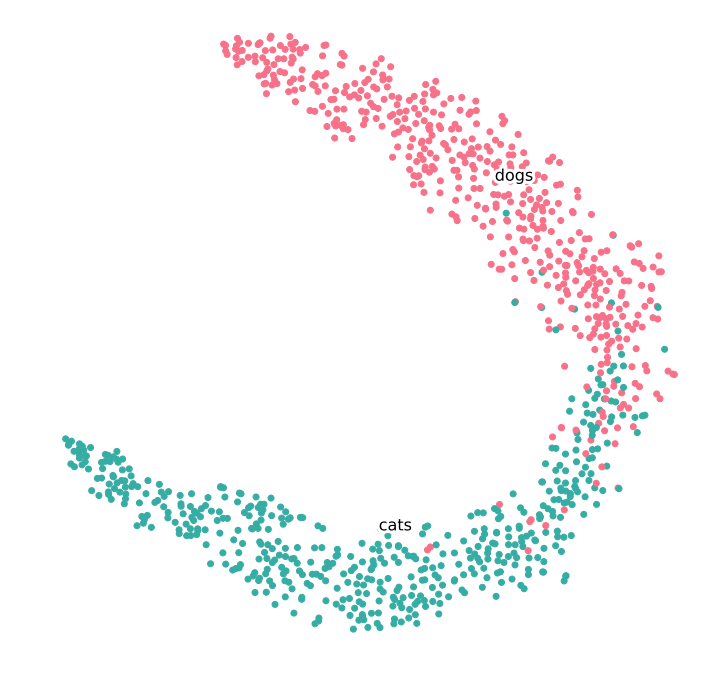

In [0]:
class_names = ['dogs', 'cats']
data_scatter(tsne, val_labels)

## Build an activation model (flatten_1)

In [0]:
layer = model.get_layer('flatten_1')
layer_output = layer.output

activation_model = models.Model(input=model.input, outputs=[layer_output])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("vg...)`
  after removing the cwd from sys.path.


In [0]:
activations = activation_model.predict(val_images)

activations.shape

(1000, 8192)

In [0]:
time_start = time.time()

tsne = TSNE(random_state=42).fit_transform(activations)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

t-SNE done! Time elapsed: 26.987706422805786 seconds


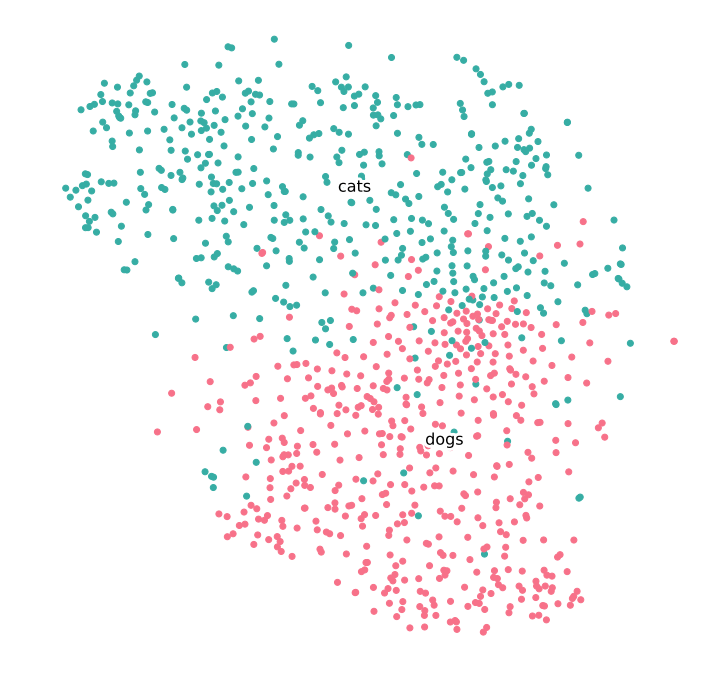

In [0]:
# visualize t-SNE output
class_names = ['dogs', 'cats']
data_scatter(tsne, val_labels)